# Feature Selection and Modeling: Upsampling

This notebook covers the basics of feature selection, modeling, and visualization for upsampled data. The goal of this notebook is to explore upsampling as a technique to solve class imbalance. 

## Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3

#Preprocessing and Feature Selection
from sklearn import preprocessing
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

#Classificatoin Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

#Classification Models, Ensemble
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

#YellowBrick Visualizers
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features.importances import FeatureImportances
from sklearn.metrics import accuracy_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Import Data

In [2]:
conn = sqlite3.connect('../data/crime_census_weather_tod.db')        
df = pd.read_sql_query("select * from all_crimes", conn)
conn.close()

df = df.dropna(how='any')

## Upsampling

The problem is shown below. By creating our target based on distances from the mean of a normal distribution, a class imbalance was created. By definition of classifying crime rates, low and high classes would be expected to make up 5% of the data.

In [3]:
df['crime_rate_cat'].value_counts() / df['crime_rate_cat'].value_counts().sum()

Med         0.670747
Low-Med     0.147534
Med-High    0.145968
High        0.020487
Low         0.015264
Name: crime_rate_cat, dtype: float64

The solution with upsampling is described below. The goal of upsampling is to take classes with less population and select randomly from them, duplicating the reports in a representative way.

1. Separate observations into three dataframes based on the classes: High, Low, and without High and Low.

In [4]:
df_majority = df[(df['crime_rate_cat'] != 'High') &
                 (df['crime_rate_cat'] != 'Low')]

df_high = df[df['crime_rate_cat'] == 'High']
df_low = df[df['crime_rate_cat'] == 'Low']

2. Resample the High and Low classes with replacement. The number of samples selected from the Low class equals the number of samples in the Low-Med class. The number of samples selected for the High class equals the number in the Med-High class.

In [5]:
df_high_upsampled = resample(df_high, 
                             replace=True,     # sample with replacement
                             n_samples=len(df[df['crime_rate_cat'] == 'Med-High']),    # to match majority class
                             random_state=123) # reproducible results

df_low_upsampled = resample(df_low, 
                            replace=True,     # sample with replacement
                            n_samples=len(df[df['crime_rate_cat'] == 'Low-Med']),    # to match majority class
                            random_state=123) # reproducible results

3. Combine the upsampled minority classes with the original majority classes.

In [6]:
df_upsampled = pd.concat([df_majority, df_high_upsampled, df_low_upsampled])
 
df_upsampled['crime_rate_cat'].value_counts() /  df_upsampled['crime_rate_cat'].value_counts().sum()

Med         0.533291
Low-Med     0.117300
Low         0.117300
High        0.116055
Med-High    0.116055
Name: crime_rate_cat, dtype: float64

## Encode/Standardize Features

#### Encode Blockgroup

In [7]:
le = preprocessing.LabelEncoder()
bg_fit = le.fit(df_upsampled['BLOCK_GROUP'])

In [8]:
df_upsampled['bg_cat'] = bg_fit.transform(df_upsampled['BLOCK_GROUP'])

#### Standardize

Standardization here means standardizing features, not targets. Standardizations tried were [StandardScalar](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), [Min-Max](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html), and [Robust](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html). Ideally, (1) pick the scalar that gives you the *least amount of variance* in your features, and (2) *scale all features*. This may seem counter intuitive. Lastly, be sure to understand the scaler you chose, even if you don't understand the scaler you did not choose. StandardScaler is intuitive for those coming from a basic background in statistics.

Lastly, the team only planned on using features that were standardized. It is not necessary to have the standardized features equal the total number of features you plan to test in the modeling.

In [9]:
feature_std = [
    'year', 'month', 'day', 'tod_num',
    'cloud_cover', 'dew_point', 'humidity', 'percip_intensity',
    'percip_probability', 'pressure', 'temperature', 'uv_index',
    'visibility', 'wind_bearing', 'wind_gust', 'wind_speed',
    'PerCapitaIncome', 'MedianHouseholdInc', 'MedianAge', 'HousingUnits',
    'weekday', 'bg_cat'
]

scaler = preprocessing.StandardScaler()
scaler_df= pd.DataFrame(scaler.fit_transform(df_upsampled[feature_std]), columns=feature_std)

C:\Users\Barbieri\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Barbieri\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


## Feature Selection

#### Feature ranking

Feature ranking with recursive feature elimination and cross-validation (rfecv).

In [10]:
feature_cols = [
    'year', 'month', 'day', 'tod_num',
    'cloud_cover', 'dew_point', 'humidity', 'percip_intensity',
    'percip_probability', 'pressure', 'temperature', 'uv_index',
    'visibility', 'wind_bearing', 'wind_gust', 'wind_speed',
    'PerCapitaIncome', 'MedianHouseholdInc', 'MedianAge',
    'weekday', 'bg_cat'
]

In [11]:
features = scaler_df[feature_cols]
target = df_upsampled['crime_rate_cat']

In [12]:
rmf = RandomForestClassifier()
rfecv = RFECV(estimator=rmf,
              step=1,
              cv=StratifiedKFold(12), #Set to 12 for production.
              scoring='accuracy',
              verbose=10,
              n_jobs=-1)

In [13]:
%%time

rfecv.fit(features, target)
print(rfecv.n_features_)

21
Wall time: 8min 22s


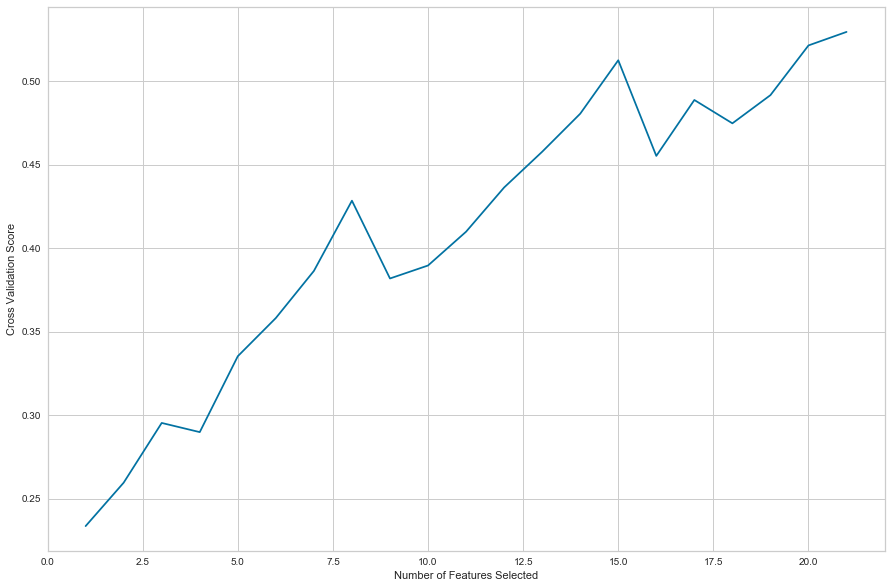

In [14]:
plt.figure(figsize=(15, 10))
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross Validation Score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

#### Feature Importances

Feature Importances are visualized using YellowBrick's [FeatureImportances visualizer](https://www.scikit-yb.org/en/latest/api/features/importances.html) and the random forest classifier.

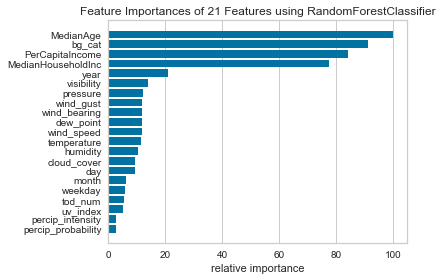

Wall time: 7.3 s


In [15]:
%%time

fig = plt.figure()
ax = fig.add_subplot()

viz = FeatureImportances(RandomForestClassifier(), ax=ax)
viz.fit(features, target)
viz.poof()

## Modeling

#### Select Features and  Target

In [16]:
feature_cols = [
    'day', 'tod_num','temperature', 'uv_index','weekday', 'bg_cat'
]

In [17]:
features = scaler_df[feature_cols]
target = df_upsampled['crime_rate_cat']

#### Split-Test-Train

In [18]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

In [19]:
classes=list(target.unique())

#### Model

- K-Nearest Neighbors Classifier
- Gradient Boosting Classifier
- Decision Tree Classifier
- Random Forest Classifier
- Extra Tree Classifier
- Bagging Classifier with Decision Tree Classifier Estimator (Default value)
- Bagging Classifier with Random Forest Classifier Estimator

In [20]:
models_list = [
    ['KNN',KNeighborsClassifier()],
    ['GradientBoosting',GradientBoostingClassifier()],
    ['DecisionTreeClassifier', DecisionTreeClassifier()],
    ['RandomForestClassifier',RandomForestClassifier()],
    ['ExtraTreesClassifier',ExtraTreesClassifier()],
    ['BC_Decision',BaggingClassifier(base_estimator=DecisionTreeClassifier())],
    ['BC_RMF',BaggingClassifier(base_estimator=RandomForestClassifier())]
]

In [21]:
%%time

models_dict = {}

for name, model in models_list:
    try:
        fit = model.fit(X_train, y_train)

        models_dict[name] = fit
        
        print("{} fitted".format(name))

    except Exception as e:
        print("{} failed; {}.".format(name, e))

        pass

KNN fitted
GradientBoosting fitted
DecisionTreeClassifier fitted
RandomForestClassifier fitted
ExtraTreesClassifier fitted
BC_Decision fitted
BC_RMF fitted
Wall time: 2min 3s


In [24]:
for name, model in models_dict.items():
    print(name, " ", accuracy_score(y_test, model.predict(X_test)))

KNN   0.6436042903997873
GradientBoosting   0.7441716159914901
DecisionTreeClassifier   0.8440297845935644
RandomForestClassifier   0.776327453239961
ExtraTreesClassifier   0.7499556776881482
BC_Decision   0.8700469816505629
BC_RMF   0.7968930059391898


#### Classification Reports

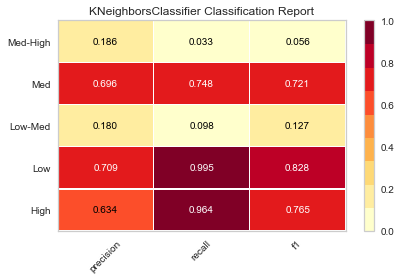

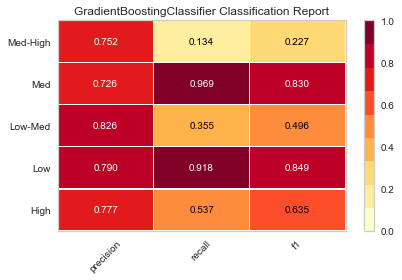

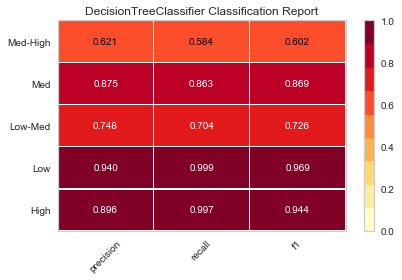

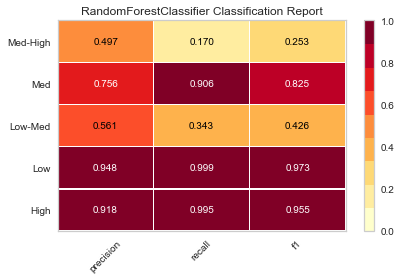

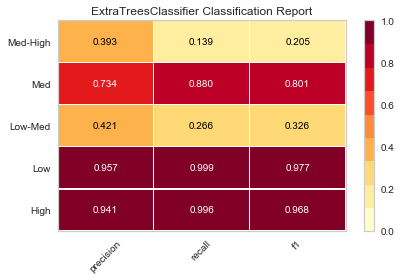

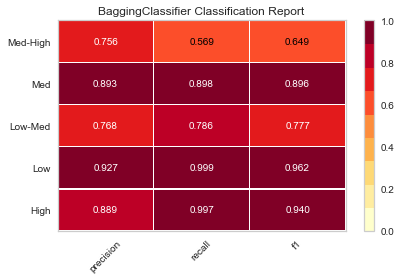

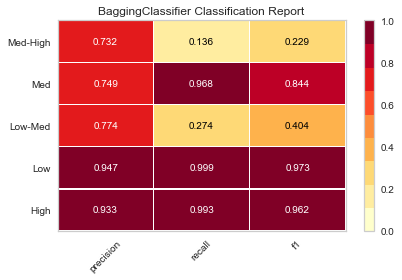

Wall time: 16.3 s


In [25]:
%%time

for name, model in models_dict.items():
    cr = ClassificationReport(model, classes=None)
    cr.score(X_test, y_test)
    cr.poof()

#### Confusion Matrix

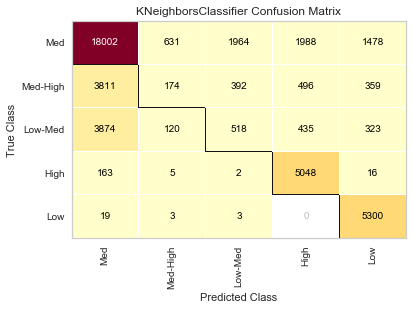

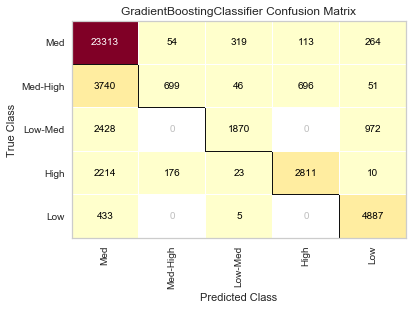

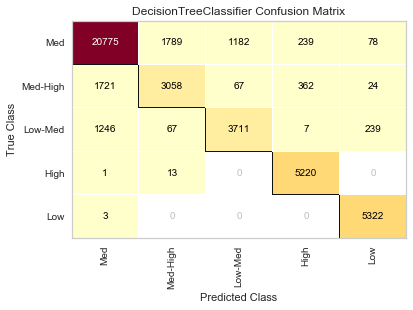

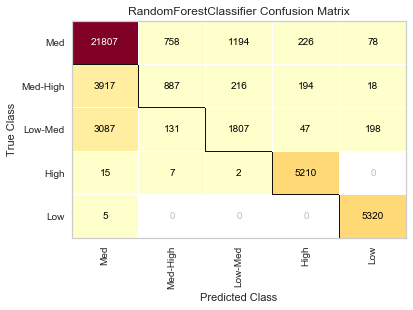

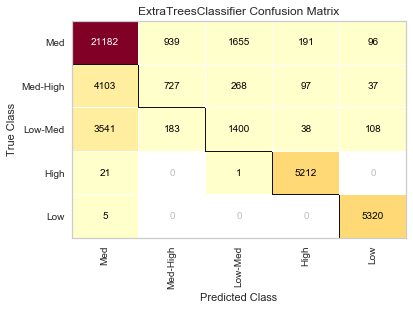

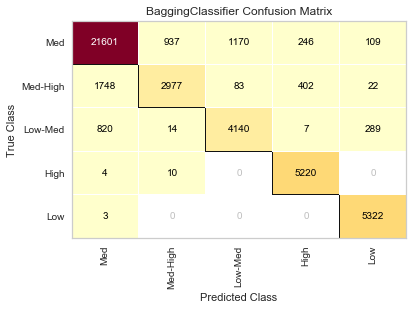

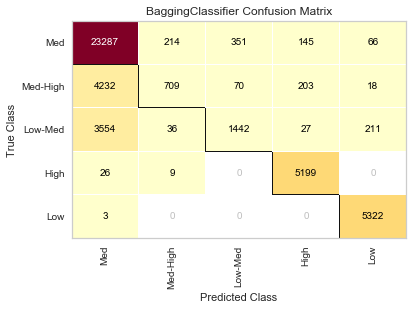

Wall time: 13 s


In [26]:
%%time

for name, model in models_dict.items():
    cm = ConfusionMatrix(model, classes=classes)
    cm.score(X_test, y_test)
    cm.poof()